In [30]:
!pip install pandas_profiling

     |████████████████████████████████| 325 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 19.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 18.2 MB/s eta 0:00:01
     |████████████████████████████████| 652 kB 24.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 25.4 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 18.0 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=2e7524e2608147637a0eb1c11f1c723845ca727a9555e02ce9c4f4bb3d9fb030
  Stored in directory: /Users/balechen/Library/Caches/pip/wheels/23/14/6e/4be5bfeeb027f4939a01764b48edd5996acf574b0913fe5243
Successfully built htmlmin


In [45]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pysal.model import spreg
import pandas_profiling

In [169]:
data = pd.read_excel('../final_processed_csv/final_full_table_12_17.xls')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25056 entries, 0 to 25055
Data columns (total 55 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   OBJECTID_1                                            25056 non-null  int64  
 1   OBJECTID                                              25056 non-null  int64  
 2   OID                                                   25056 non-null  int64  
 3   FID_fishnet2_label                                    25056 non-null  int64  
 4   X                                                     25056 non-null  float64
 5   Y                                                     25056 non-null  float64
 6   clipped_chn_f_0_2020_constrained_UNadj                15288 non-null  float64
 7   clipped_chn_f_1_2020_constrained_UNadj                15288 non-null  float64
 8   clipped_chn_f_10_2020_constrained_UNadj               15

# Data Cleaning

In [170]:
data_cleaned = pd.DataFrame()
# coordinates
data_cleaned['lng'], data_cleaned['lat'] = data['X'], data['Y']

# demographic
data_cleaned['NTL'] = data['NTL_Shanghai_Clipped']
data_cleaned['female_pop'] = data.iloc[:,7:25].sum(axis=1)
data_cleaned['male_pop'] = data.iloc[:,25:42].sum(axis=1)
data_cleaned['age_0_20'] = data.iloc[:,[7,8,9,10,17,25,26,27,28,35]].sum(axis=1)
data_cleaned['age_20_30'] = data.iloc[:,[11,12,29,30]].sum(axis=1)
data_cleaned['age_30_40'] = data.iloc[:,[13,15,31,32]].sum(axis=1)
data_cleaned['age_40_50'] = data.iloc[:,[14,16,33,34]].sum(axis=1)
data_cleaned['age_20_50'] = data.iloc[:,[11,12,29,30,13,15,31,32,14,16,33,34]].sum(axis=1)
data_cleaned['age_50+'] = data.iloc[:,[18,20,36,37,19,21,22,23,24,38,39,40,41]].sum(axis=1)

# socioeconomic
# data_cleaned['housing_price_idw_1'] = data['housing_price_idw_1']
# data_cleaned['housing_price_idw_2'] = data['housing_price_idw_2']
data_cleaned['housing_price_idw_3'] = data['housing_price_idw_3']
data_cleaned['road_network_kd'] = data['road_network_kernel_density_clipped']

# land use
data_cleaned['poi_commerical_kd'] = data['fill_again_clippedfilledpoi_POI_Label_commercial_']
data_cleaned['poi_greenspace_kd'] = data['fill_again_clippedfilledpoi_POI_Label_greenspace']
data_cleaned['poi_industrial_kd'] = data['fill_again_clippedfilledpoi_POI_Label_industrial']
data_cleaned['poi_institutional_kd'] = data['fill_again_clippedfilledpoi_POI_Label_institutional']
data_cleaned['poi_residential_kd'] = data['fill_again_clippedfilledpoi_POI_Label_residential']
data_cleaned['poi_transportation_kd'] = data['fill_again_clippedfilledpoi_POI_Label_transportation']



# accessibility
data_cleaned['y'] = data['accessibility_gravity_model_adjusted']

#district
replace_map = {
    "黄浦区": "Huangpu",
    "静安区": "Jingan",
    "徐汇区": "Xuhui",
    "杨浦区": "Yangpu",
    "闵行区": "Minhang",
    "长宁区": "Changning",
    "普陀区": "Putuo",
    "虹口区": "Hongkou",
    "宝山区": "Baoshan",
    "嘉定区": "Jiading",
    "浦东新区": "Pudong",
    "金山区": "Jinshan",
    "松江区": "Songjiang",
    '青浦区': "Qingpu",
    '奉贤区': "Fengxian"
}
data_cleaned['district'] = data['district'].replace(replace_map)

data_cleaned = data_cleaned.fillna(0)
data_cleaned.describe(include='all')

,lng,lat,NTL,female_pop,male_pop,age_0_20,age_20_30,age_30_40,age_40_50,age_20_50,...,housing_price_idw_3,road_network_kd,poi_commerical_kd,poi_greenspace_kd,poi_industrial_kd,poi_institutional_kd,poi_residential_kd,poi_transportation_kd,y,district
count,25056.000000,25056.000000,25056.000000,25056.000000,25056.000000,25056.000000,25056.000000,25056.000000,25056.000000,25056.000000,...,25056.000000,25056.000000,25056.000000,25056.000000,25056.000000,25056.000000,25056.000000,25056.000000,25056.000000,25056
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pudong
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5939
mean,121.396867,31.092435,19.783863,21.324705,26.817709,11.725005,9.777833,5.803406,4.635834,20.217073,...,39462.407440,72.779149,1.273654,0.089876,0.012065,0.665955,0.112675,0.325969,4.888370,NaN
std,0.226715,0.180804,17.749644,34.799995,49.361045,18.914250,14.186388,8.351358,6.718083,29.205251,...,17471.918308,97.050694,4.001434,0.284556,0.107328,2.187470,0.527983,1.105709,29.954156,NaN
min,120.892273,30.696716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,121.222290,30.947510,6.320000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,28641.295410,25.490975,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
50%,121.376282,31.075073,15.905000,9.944047,12.003877,5.569344,4.607315,3.004344,2.405748,10.082291,...,37335.876953,53.321106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
75%,121.569885,31.233521,29.790001,27.108035,33.323207,15.133424,13.598685,8.065420,6.389107,28.080590,...,46720.986328,92.112959,0.736340,0.000000,0.000000,0.373511,0.000000,0.033520,3.415403,NaN


In [171]:
mask2 = np.abs(stats.zscore(data_cleaned.y)) <= 3
data_cleaned = data_cleaned[mask2]

# data_cleaned.iloc[:,2:] = (data_cleaned.iloc[:,2:] - data_cleaned.iloc[:,2:].mean())/data_cleaned.iloc[:,2:].std()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_cleaned.iloc[:,2:-1] = scaler.fit_transform(data_cleaned.iloc[:,2:-1].to_numpy())

data_cleaned.describe(include="all")
# Combine all the poi features to reduce multicollinearity
# temp = data_cleaned[['heatmap_parks',
#     'heatmap_shopping_centers',
#     'heatmap_parking',
#     'heatmap_hotels',
#     'heatmap_hospitals',
#     'heatmap_catering']].values

# poi_density = np.sum(temp, axis=1)

# data_cleaned['poi_density'] = poi_density

# data_cleaned = data_cleaned.drop(['heatmap_parks',
#     'heatmap_shopping_centers',
#     'heatmap_parking',
#     'heatmap_hotels',
#     'heatmap_hospitals',
#     'heatmap_catering'], axis=1)

,lng,lat,NTL,female_pop,male_pop,age_0_20,age_20_30,age_30_40,age_40_50,age_20_50,...,housing_price_idw_3,road_network_kd,poi_commerical_kd,poi_greenspace_kd,poi_industrial_kd,poi_institutional_kd,poi_residential_kd,poi_transportation_kd,y,district
count,25012.000000,25012.000000,2.501200e+04,2.501200e+04,2.501200e+04,2.501200e+04,2.501200e+04,2.501200e+04,2.501200e+04,2.501200e+04,...,2.501200e+04,2.501200e+04,2.501200e+04,2.501200e+04,2.501200e+04,2.501200e+04,2.501200e+04,2.501200e+04,2.501200e+04,25012
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pudong
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5932
mean,121.396838,31.092273,1.595335e-16,-3.682114e-14,2.281645e-14,-4.525063e-14,3.011683e-14,-5.700160e-14,1.955836e-14,2.772286e-14,...,1.540814e-15,-2.165001e-15,-1.147871e-14,-3.407642e-14,1.828926e-14,2.812732e-14,-1.059774e-14,2.754703e-14,-6.523966e-14,NaN
std,0.226826,0.180874,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,...,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,NaN
min,120.892273,30.696716,-1.117883e+00,-6.138031e-01,-6.584488e-01,-6.209958e-01,-6.894766e-01,-6.958036e-01,-6.908934e-01,-6.927903e-01,...,-2.262774e+00,-7.518999e-01,-3.181852e-01,-3.153265e-01,-1.121537e-01,-3.043448e-01,-2.124585e-01,-2.943645e-01,-5.374013e-01,NaN
25%,121.222290,30.947510,-7.601789e-01,-6.138031e-01,-6.330076e-01,-6.209958e-01,-6.894766e-01,-6.958036e-01,-6.908934e-01,-6.927903e-01,...,-6.193729e-01,-4.880405e-01,-3.181852e-01,-3.153265e-01,-1.121537e-01,-3.043448e-01,-2.124585e-01,-2.943645e-01,-4.047308e-01,NaN
50%,121.376282,31.075073,-2.184886e-01,-3.268804e-01,-3.543736e-01,-3.252562e-01,-3.644914e-01,-3.353274e-01,-3.318133e-01,-3.469205e-01,...,-1.203933e-01,-1.997871e-01,-3.181852e-01,-3.153265e-01,-1.121537e-01,-3.043448e-01,-2.124585e-01,-2.943645e-01,-4.047308e-01,NaN
75%,121.569885,31.233521,5.665337e-01,1.684706e-01,1.841218e-01,1.824766e-01,2.705545e-01,2.729659e-01,2.636929e-01,2.709835e-01,...,4.175882e-01,2.016016e-01,-1.333375e-01,-3.153265e-01,-1.121537e-01,-1.328096e-01,-2.124585e-01,-2.651193e-01,-8.902269e-02,NaN


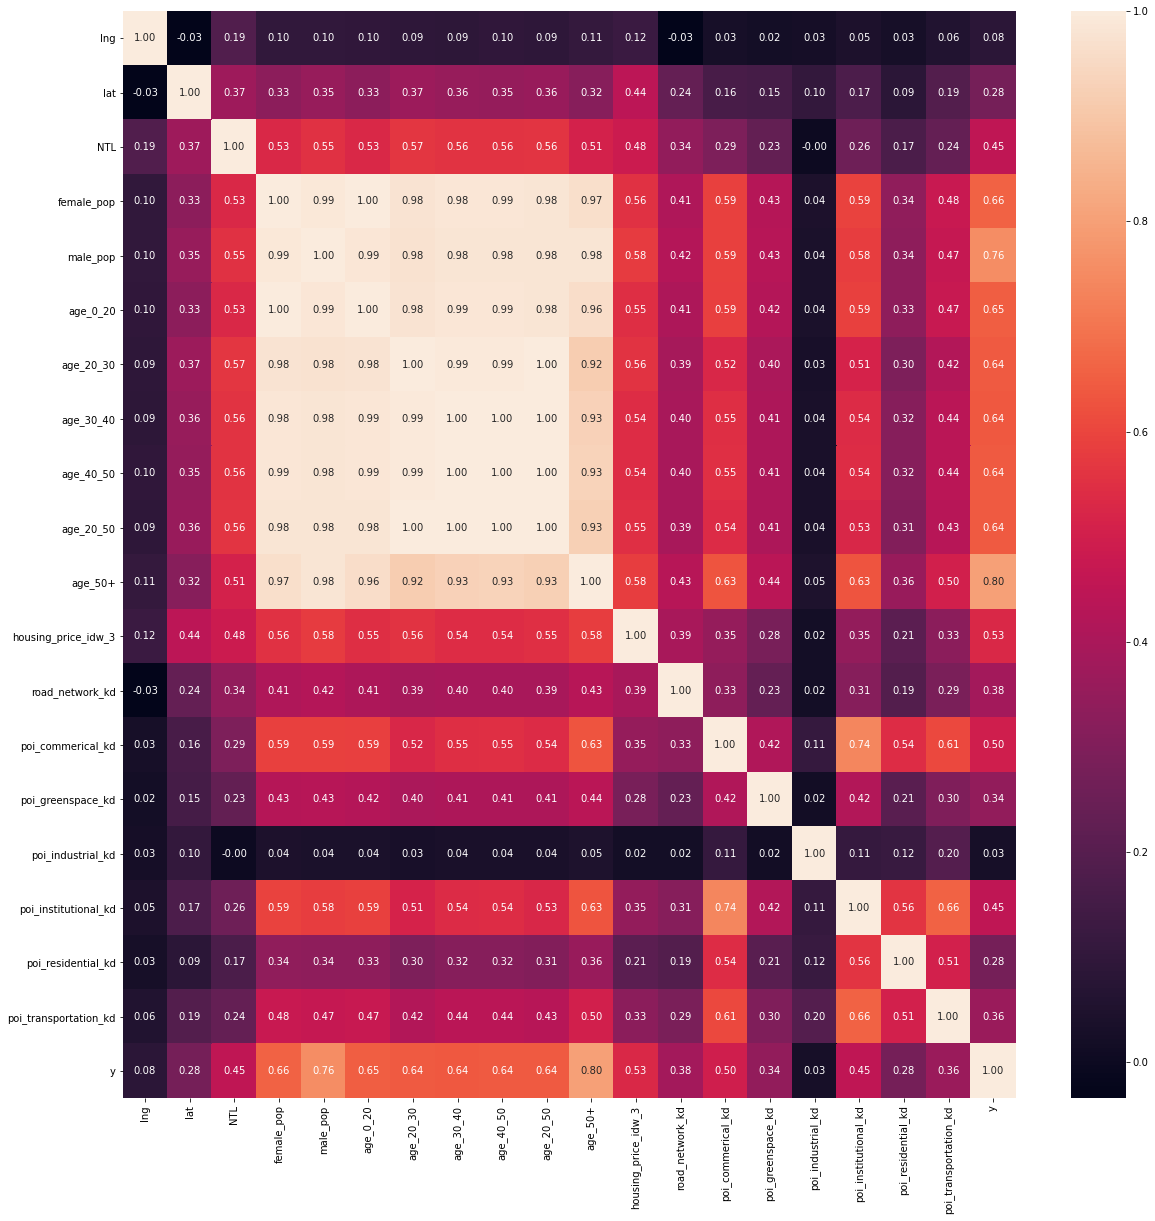

In [92]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data_cleaned.corr(), annot=True,  fmt=".2f", ax=ax)
# plt.show()
plt.savefig("../figures/correlation.png", dpi=300)

In [187]:
y = data_cleaned.y.values
X_names = [
    'NTL',
    'female_pop',
    'male_pop',
#     'age_0_20',
#     'age_20_30',
#     'age_30_40', 
#     'age_40_50', 
#     'age_50+', 
    'age_20_50',
# #     'housing_price_idw_1',
# #     'housing_price_idw_2', 
    'housing_price_idw_3', 
    'road_network_kd',
    'poi_commerical_kd', 
#     'poi_greenspace_kd', 
    'poi_industrial_kd',
#     'poi_institutional_kd', 
    'poi_residential_kd', 
    'poi_transportation_kd'
]
X = data_cleaned[X_names].values

In [188]:
linreg = spreg.OLS(y, X, 
                   name_y="accessbility",
                   name_x=X_names,
                   white_test=True)

In [189]:
print(linreg.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :accessbility                Number of Observations:       25012
Mean dependent var  :     -0.0000                Number of Variables   :          11
S.D. dependent var  :      1.0000                Degrees of Freedom    :       25001
R-squared           :      0.9805
Adjusted R-squared  :      0.9805
Sum squared residual:     486.770                F-statistic           : 125964.1791
Sigma-square        :       0.019                Prob(F-statistic)     :           0
S.E. of regression  :       0.140                Log likelihood        :   13774.647
Sigma-square ML     :       0.019                Akaike info criterion :  -27527.294
S.E of regression ML:      0.1395                Schwarz criterion     :  -27437.896

-----------------------------------------------------------------------------

# GWR

In [55]:
import libpysal as ps
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

import warnings
warnings.filterwarnings("ignore")

In [204]:
coords = data_cleaned[['lng', 'lat']].values

y = data_cleaned.y.values[:, np.newaxis]
X_names = [
    'NTL',
    'female_pop',
    'male_pop',
#     'age_0_20',
#     'age_20_30',
#     'age_30_40', 
#     'age_40_50', 
#     'age_50+', 
    'age_20_50',
#     'housing_price_idw_1',
#     'housing_price_idw_2', 
    'housing_price_idw_3', 
    'road_network_kd',
    'poi_commerical_kd', 
    'poi_greenspace_kd', 
    'poi_industrial_kd',
    'poi_institutional_kd', 
    'poi_residential_kd', 
    'poi_transportation_kd'
]
X = data_cleaned[X_names].values

print(coords.shape)
print(X.shape)
print(y.shape)

(25012, 2)
(25012, 12)
(25012, 1)


In [201]:
bw = Sel_BW(coords, y, X, fixed=True, kernel='gaussian').search(criterion='AIC', verbose=True)

Exception: all input data must be either numpy arrays or sparse csr matrices

In [207]:
model = GWR(coords, y, X, bw=5, fixed=True, kernel='gaussian', spherical=True)

In [208]:
results = model.fit()

In [209]:
results.summary()

Model type                                                         Gaussian
Number of observations:                                               25012
Number of covariates:                                                    13

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            486.733
Log-likelihood:                                                   13775.584
AIC:                                                             -27525.167
AICc:                                                            -27523.150
BIC:                                                            -252680.914
R2:                                                                   0.981
Adj. R2:                                                              0.981

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
 0.009      0.074     -0.344      0.020      0.167
 0.001      0.009     -0.046     -0.000      0.052
-2.871      0.745     -6.224     -2.849     -1.004
 5.201      0.069      4.775      5.215      5.400
-1.599      0.599     -3.045     -1.652      0.908
 0.010      0.026     -0.004      0.001      0.179
 0.003      0.015     -0.030      0.000      0.115
 0.004      0.009     -0.009      0.000      0.036
-0.001      0.004     -0.022     -0.000      0.008
 0.001      0.003     -0.017      0.000      0.018
 0.000      0.008     -0.032     -0.000      0.043
 0.000      0.007     -0.020      0.000      0.024
 0.000      0.007     -0.029      0.000      0.018

# Statistics

In [23]:
np.median(np.array([1,2,3,4,5]))

3.0

In [38]:
def generate_sum_table(data, x, y):
    print("="*25)
    for item in y.unique():
        temp_mask = y==item
        x_masked = x[temp_mask].values
        print(f"{item} & {round(x_masked.mean()-1, 2)} & {round(np.median(x_masked)-1, 2)} & {round(x_masked.std(),2)} \\\\")

In [39]:
generate_sum_table(data_cleaned, data_cleaned["y"], data_cleaned["district"])

Huangpu & 16.48 & 17.4 & 5.53 \\
Xuhui & 9.52 & 7.67 & 7.53 \\
Changning & 10.38 & 10.9 & 7.16 \\
Jingan & 16.03 & 17.1 & 6.45 \\
Putuo & 10.16 & 10.06 & 6.85 \\
Hongkou & 13.03 & 12.59 & 6.46 \\
Yangpu & 10.54 & 10.15 & 7.34 \\
Minhang & 5.94 & 4.11 & 6.11 \\
Baoshan & 4.06 & 1.5 & 5.67 \\
Jiading & 2.19 & 0.0 & 4.32 \\
Pudong & 2.63 & 0.0 & 4.62 \\
Jinshan & 0.0 & 0.0 & 0.35 \\
Songjiang & 1.06 & 0.0 & 2.67 \\
Qingpu & 0.66 & 0.0 & 2.1 \\
Fengxian & 0.12 & 0.0 & 0.94 \\


In [33]:
report = pandas_profiling.ProfileReport(data_cleaned)
report.to_file('../statistical_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]